# Machine Learning example on _1 billion_ samples: N. Y. CityCabs data

### Predict the likely duration of a taxi trip

In [1]:
import vaex
import vaex.ml
from vaex.ui.colormaps import cm_plusmin

import numpy as np

import pylab as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

### Adjusting `matplotlib` parameters

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Read in the data

- Can "read" the memmory mapped file that we have on disk in no time.
- `Vaex` can also read data stored on S3. The data is streamed on need-to-have basis and is locally cached.

In [3]:
# Check the file size on disk
!ls -l -h /data/yellow_taxi_2009_2015_f32.hdf5

-rwxrwxr-x 1 maartenbreddels adm 108G mei  4  2020 /data/yellow_taxi_2009_2015_f32.hdf5


In [4]:
# Read in the data from disk
df = vaex.open('/data/yellow_taxi_2009_2015_f32.hdf5')

### Split the data into train & test sets

- All data prior to 2015 is train;
- All data of 2015 is test.

In [5]:
# Train / test split (by date)
df_train = df[:1_026_944_937]
df_test = df[1_026_944_937:]

print('Number of samples in the training set: %i' % len(df_train))
print('Number of samples in the test set: %i' % len(df_test))

# Check if the lengths of the datasets match
assert len(df) == len(df_test) + len(df_train)

Number of samples in the training set: 1026944937
Number of samples in the test set: 146112990


### Initial feature generation

In [6]:
# Time in transit (minutes) - This is the target variable
df_train['trip_duration_min'] = (df_train.dropoff_datetime - df_train.pickup_datetime) / \
                                   np.timedelta64(1, 'm')

# Speed (miles per hour) - To be used for cleaning of the training data
df_train['trip_speed_mph'] = df_train.trip_distance / \
                                ((df_train.dropoff_datetime - df_train.pickup_datetime) / \
                                np.timedelta64(1, 'h'))

### Data cleaning

- To get better insight into how the data has been cleaned, please check [this Notebook](https://nbviewer.jupyter.org/github/vaexio/vaex-examples/blob/master/medium-nyc-taxi-data-eda/vaex-taxi-article.ipynb).

In [7]:
# Drop NA from relevant fields
df_train = df_train.dropna(column_names=['dropoff_latitude', 'dropoff_longitude', 'pickup_latitude'])

# Filter abnormal number of passengers
df_train = df_train[(df_train.passenger_count>0) & (df_train.passenger_count<7)]

# Select taxi trips have travelled maximum 100 miles (but also with non-zero distance).
df_train = df_train[(df_train.trip_distance > 0) & (df_train.trip_distance < 10)]

# # Filter taxi trips that have unreasonably long dirations or that lasted less than 1 minute
df_train = df_train[(df_train.trip_duration_min > 2) & (df_train.trip_duration_min < 30)]

# Filter out errouneous average trip speeds.
df_train = df_train[(df_train.trip_speed_mph > 1) & (df_train.trip_speed_mph < 60)]

# Define the NYC boundaries
long_min = -74.05
long_max = -73.75
lat_min = 40.58
lat_max = 40.90

# Make a selection based on the boundaries
df_train = df_train[(df_train.pickup_longitude > long_min)  & (df_train.pickup_longitude < long_max) & \
                    (df_train.pickup_latitude > lat_min)    & (df_train.pickup_latitude < lat_max) & \
                    (df_train.dropoff_longitude > long_min) & (df_train.dropoff_longitude < long_max) & \
                    (df_train.dropoff_latitude > lat_min)   & (df_train.dropoff_latitude < lat_max)]

### Create some additional features:

In [8]:
# Pickup datetime features
df_train['pickup_time'] = df_train.pickup_datetime.dt.hour + df_train.pickup_datetime.dt.minute / 60.
df_train['pickup_day'] = df_train.pickup_datetime.dt.dayofweek
df_train['pickup_month'] = df_train.pickup_datetime.dt.month - 1 # so it starts from 0
df_train['pickup_is_weekend'] = (df_train.pickup_day>=5).astype('int')

In [9]:
# Arc distance  in miles
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

# Create the feature
df_train['arc_distance'] = arc_distance(df_train.pickup_longitude, 
                                        df_train.pickup_latitude, 
                                        df_train.dropoff_longitude, 
                                        df_train.dropoff_latitude).jit_numba()

In [10]:
# Direction of travel in degrees
def direction_angle(theta_1, phi_1, theta_2, phi_2):
    dtheta = theta_2 - theta_1
    dphi = phi_2 - phi_1
    radians = np.arctan2(dtheta, dphi)
    return np.rad2deg(radians)

# Create the feature
df_train['direction_angle'] = direction_angle(df_train.pickup_longitude, 
                                              df_train.pickup_latitude, 
                                              df_train.dropoff_longitude, 
                                              df_train.dropoff_latitude).jit_numba()

### Transform features: PCA of the pick-up and drop-off locations

In [11]:
# PCA of the pickup and dropoff locations - helps to "straighten out" the coordinates

# pickup transformations
pca_pickup = vaex.ml.PCA(features=['pickup_longitude', 'pickup_latitude'], n_components=2)
df_train = pca_pickup.fit_transform(df_train)

# dropoff transformations
pca_dropoff = vaex.ml.PCA(features=['dropoff_longitude', 'dropoff_latitude'], n_components=2)
df_train = pca_dropoff.fit_transform(df_train)

In [12]:
# # Visualise to make sure this makes sense
# plt.figure(figsize=(14, 10))

# plt.subplot(221)
# plt.title('pickup - original')
# df_train.plot(df_train.pickup_longitude, df_train.pickup_latitude,
#               limits='minmax', f='log1p', shape=256,
#               colormap='plasma', colorbar=False)

# plt.subplot(222)
# plt.title('pickup - PCA transformed')
# df_train.plot(df_train.PCA_0, df_train.PCA_1,
#               limits='minmax', f='log1p', shape=256,
#               colormap='plasma', colorbar=False)

# plt.subplot(223)
# plt.title('dropoff - original')
# df_train.plot(df_train.dropoff_longitude, df_train.dropoff_latitude,
#               limits='minmax', f='log1p', shape=256,
#               colormap='plasma', colorbar=False)

# plt.subplot(224)
# plt.title('dropoff - PCA transformed')
# df_train.plot(df_train.PCA_2, df_train.PCA_3,
#               limits='minmax', f='log1p', shape=256,
#               colormap='plasma', colorbar=False)

# plt.tight_layout()
# plt.show()

### Handling temporal (cyclical) features

In [13]:
# Time
df_train['pickup_time_x'] = (np.sin(2 * np.pi * df_train.pickup_time / 24.)).jit_numba()
df_train['pickup_time_y'] = (np.cos(2 * np.pi * df_train.pickup_time / 24.)).jit_numba()
# Day
df_train['pickup_day_x'] = (np.sin(2 * np.pi * df_train.pickup_day / 7.)).jit_numba()
df_train['pickup_day_y'] = (np.cos(2 * np.pi * df_train.pickup_day / 7.)).jit_numba()
# Month
df_train['pickup_month_x'] = (np.sin(2 * np.pi * df_train.pickup_month / 12.)).jit_numba()
df_train['pickup_month_y'] = (np.cos(2 * np.pi * df_train.pickup_month / 12.)).jit_numba()
# Direction angle:
df_train.direction_angle
df_train['direction_angle_x'] = (np.sin(2 * np.pi * df_train.direction_angle / 360.)).jit_numba()
df_train['direction_angle_y'] = (np.cos(2 * np.pi * df_train.direction_angle / 360.)).jit_numba()


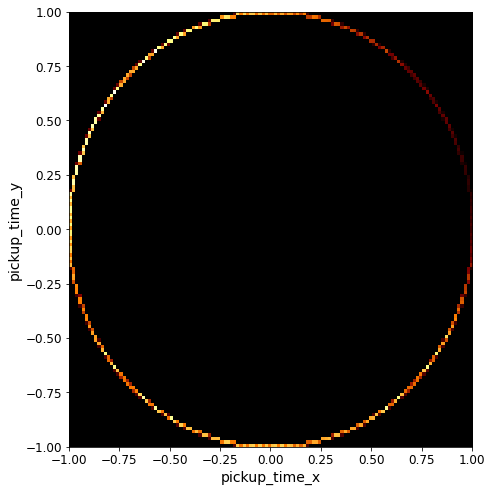

In [14]:
# Let's see how the transformed date would look like
df_train.plot(x='pickup_time_x', y='pickup_time_y', 
              shape=128, limits='minmax',
              figsize=(7, 7),
              colorbar=False)
plt.show()

# The circle is mathematical so: 
# "midnight" has coordinates (x, y) = (1, 0); 
# "3 o'clock" has coordinates (x, y) = (0, 1)

### Scaling of numerical features

In [15]:
# Standard scaling of numerical features
standard_scaler = vaex.ml.StandardScaler(features=['arc_distance', 'trip_distance'])
df_train = standard_scaler.fit_transform(df_train)

### Preview the training features

In [16]:
# Select all the features to be used for training the model
features = df_train.get_column_names(regex='PCA*') + \
           df_train.get_column_names(regex='standard_scaled_*') + \
           df_train.get_column_names(regex='.*_x') + \
           df_train.get_column_names(regex='.*_y') + \
           ['pickup_is_weekend']

# Preview the features
df_train.head(10)[features]

#,PCA_0,PCA_1,PCA_2,PCA_3,standard_scaled_arc_distance,standard_scaled_trip_distance,pickup_time_x,pickup_day_x,pickup_month_x,direction_angle_x,pickup_time_y,pickup_day_y,pickup_month_y,direction_angle_y,pickup_is_weekend
0,-0.0307354,-0.0119386,-0.0546394,-0.0217794,-0.635183,0.220329,0.681998,-0.781831,0,-0.0718163,0.731354,0.62349,1,-0.997418,1
1,-0.013279,-0.00889608,0.0255888,-0.00752069,0.536175,1.31678,0.796002,-0.781831,0,0.637374,0.605294,0.62349,1,0.770554,1
2,0.0316626,0.0231954,-0.0279566,0.00243531,0.532888,1.57376,-0.731354,0.433884,0,-0.35291,0.681998,-0.900969,1,-0.935657,0
3,-0.0389584,-0.00648876,-0.0442893,0.00471265,-0.664232,-1.05316,-0.902585,-0.974928,0,-0.990071,-0.430511,-0.222521,1,0.140566,1
4,-0.019531,-0.00421181,-0.0266882,-0.0111865,-0.733785,-0.5963,-0.362438,-0.433884,0,0.414276,0.932008,-0.900969,1,-0.910151,0
5,-0.00937607,-0.00247773,-0.0044752,4.01984e-05,-0.821695,-1.05316,0.722364,0.974928,0,0.575407,-0.691513,-0.222521,1,0.817867,0
6,-0.0118258,0.00706228,-0.0301562,-0.000509916,-0.695123,-0.299344,0.925541,-0.781831,0,-0.145266,0.378649,0.62349,1,-0.989393,1
7,0.00466276,-0.00892432,-0.00899492,0.00937816,0.136528,-0.367872,-0.922201,0,0,-0.996086,-0.386711,1,1,0.0883861,0
8,0.0391315,0.00392159,0.0292692,-0.00118381,-0.819069,-0.881835,-0.973379,0,0,-0.384646,0.2292,1,1,-0.923064,0
9,-0.0210772,0.0168473,0.00735006,0.00691713,0.550952,0.0318763,0.995805,0,0,0.891606,-0.0915016,1,1,0.452811,0


In [17]:
# The target variable
target = 'trip_duration_min'

### ML modelling

In [19]:
from vaex.ml.vowpalwabbit import VowpalWabbitModel
import vaex.ml.metrics

# Set up the model
params = {'quiet': True}
model = VowpalWabbitModel(features=features, 
                          target=target,
                          params=params,
                          prediction_name='pred', 
                          batch_size=11_000_000,
                         )

# Fit the model
model.fit(df_train, progress='widget')

KeyboardInterrupt: 

### Check performance

In [31]:
df_train = model.transform(df_train)

# Do somet clipping
df_train['pred_final'] = df_train.pred.clip(3, 25)

# Preview the results
df_train.head(5)['trip_duration_min', 'pred', 'pred_final']

#,trip_duration_min,pred,pred_final
0,10,0.167554,3
1,7,0.302589,3
2,21.0333,0.344418,3
3,6.55,0.153082,3
4,7.6,0.116975,3


In [33]:
# State transfer
state = df_train.state_get()
df_test.state_set(state)

In [34]:
# See metrics
print('Mean absolute error:', df_test.ml.metrics.mean_absolute_error(target, 'pred'))
print('Mean squared error:', df_test.ml.metrics.mean_squared_error(target, 'pred'))

Mean absolute error: 11.443368618022271
Mean squared error: 171.3573907951725
